In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-12-08T20:09:36.470447+03:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.28.0

Compiler    : GCC 14.2.1 20241116
OS          : Linux
Release     : 6.12.3-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [3]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)
        area = requests.get(f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-12-08: 100%|██████████| 1122/1122 [17:57<00:00,  1.04it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
5919,#ff5252,139991.513798,23.189,other_territories,2024-12-08 02:15:50
5920,#a52714,67560.107309,11.191,occupied_after_24_02_2022,2024-12-08 02:15:50
5921,#880e4f,43968.885566,7.283,occupied_to_24_02_2022,2024-12-08 02:15:50
5922,#bdbdbd,177.132377,0.029,other_territories,2024-12-08 02:15:50


In [4]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [5]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [6]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [7]:
df

,hash,area,percent,type
time_index,,,,
2022-04-03 15:33:28,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
2022-04-03 15:33:28,#880e4f,46937.208199,7.775000,occupied_to_24_02_2022
2022-04-03 15:33:28,#bcaaa4,5587.522472,0.926000,unspecified
2022-04-03 15:33:28,#0f9d58,14012.882652,2.321000,liberated
2022-04-03 19:46:15,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
...,...,...,...,...
2024-12-08 02:15:50,#ff5252,139991.513798,23.188999,other_territories
2024-12-08 02:15:50,#a52714,67560.107309,11.191000,occupied_after_24_02_2022
2024-12-08 02:15:50,#880e4f,43968.885566,7.283000,occupied_to_24_02_2022


In [8]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_29632/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [9]:
occupied_by_ua = (
    df[(df["type"] == "other_territories") & (df["hash"] == "#01579b")]
    .groupby(pd.Grouper(freq="D"))[["area", "percent"]]
    .mean()
    .fillna(0)
)
occupied_by_ua

,area,percent
time_index,,
2024-08-08,142.989574,0.024
2024-08-09,142.989574,0.024
2024-08-10,142.989574,0.024
2024-08-11,142.989574,0.024
2024-08-12,313.306949,0.052
...,...,...
2024-12-04,546.321161,0.090
2024-12-05,546.321161,0.090
2024-12-06,546.321161,0.090


In [10]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-12-08                    liberated
2024-12-08    occupied_after_24_02_2022
2024-12-08       occupied_to_24_02_2022
2024-12-08            other_territories
2024-12-08                  unspecified
Name: type, Length: 4439, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [11]:
area_dinamic["type"].unique()

['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'unspecified', 'other_territories']
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [12]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [13]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [14]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-12-04,67517.409189,0
2024-12-05,67534.337645,0
2024-12-06,67540.912862,0
2024-12-07,67547.779706,0


In [15]:
aa["area"] = aa["area"].subtract(occupied_by_ua["area"], fill_value=0)
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-12-04,66971.088028,0
2024-12-05,66988.016484,0
2024-12-06,66994.591700,0
2024-12-07,67001.458545,0


In [16]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     648.4
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:27:50   Log-Likelihood:                -9058.1
No. Observations:                 981   AIC:                         1.813e+04
Df Residuals:                     974   BIC:                         1.816e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   920.6579    143.265      6.426      0.000     639.514    1201.802
cos(1,730.50)   873.5539    179.043      4.879      0.000     522.200    1224.908
sin(2,730.50)  1437.4223    124.868     11.512      0.000    1192.382    1682.463
cos(2,730.50)  -244.2763    133.860     -1.825      0.068    -506.964      18.411
prefix         8194.8846    516.859     15.855      0.000    7180.598    9209.171
const          6.695e+04    410.961    162.917      0.000    6.61e+04    6.78e+04
trend            -3.1974      0.667     -4.796      0.000      -4.506      -1.889
==============================================================================
Omnibus:                      223.786   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              781.231
Skew:                          -1.073   Prob(JB):                    2.28e-170
Kurtosis:                       6.809   Cond. No.                     4.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

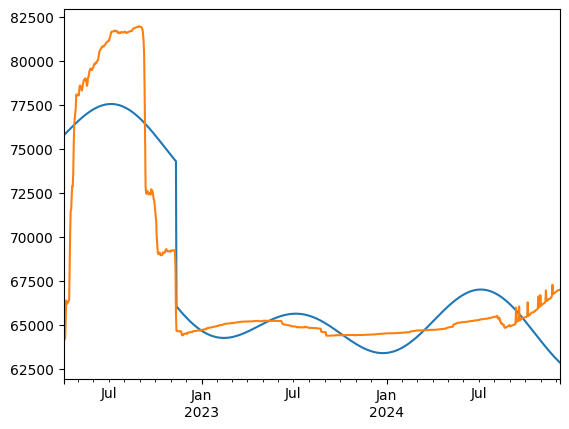

In [17]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [18]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-12-04,66971.088028,0
2024-12-05,66988.016484,0
2024-12-06,66994.591700,0
2024-12-07,67001.458545,0


In [19]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-12-04,0,0,1.0,977.0
2024-12-05,0,0,1.0,978.0
2024-12-06,0,0,1.0,979.0
2024-12-07,0,0,1.0,980.0


In [20]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  981
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -6607.314
Date:                Sun, 08 Dec 2024   AIC                          13234.628
Time:                        20:28:07   BIC                          13283.503
Sample:                    04-03-2022   HQIC                         13253.222
                         - 12-08-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7248      0.091      7.931      0.000       0.546       0.904
ar.L2         -0.3453      0.093     -3.730      0.000      -0.527      -0.164
ar.L3          0.3743      0.082      4.584      0.000       0.214       0.534
ar.L4          0.5119      0.086      5.977      0.000       0.344       0.680
ar.L5         -0.2970      0.024    -12.607      0.000      -0.343      -0.251
ma.L1         -0.3081      0.094     -3.278      0.001      -0.492      -0.124
ma.L2          0.2924      0.060      4.846      0.000       0.174       0.411
ma.L3         -0.3789      0.063     -6.018      0.000      -0.502      -0.256
ma.L4         -0.4707      0.070     -6.705      0.000      -0.608      -0.333
sigma2      3.557e+04    362.749     98.070      0.000    3.49e+04    3.63e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.08   Jarque-Bera (JB):             92578.06
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -3.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-12-09,67062.414550,188.612943,66692.739974,67432.089126
2024-12-10,67088.073023,327.080867,66447.006303,67729.139742
2024-12-11,67076.229653,453.559786,66187.268808,67965.190499
2024-12-12,67079.741633,555.240973,65991.489323,68167.993942
2024-12-13,67117.212097,654.024275,65835.348073,68399.076122
...,...,...,...,...
2025-04-03,67702.049799,6605.615741,54755.280851,80648.818746
2025-04-04,67703.916601,6648.066516,54673.945663,80733.887538
2025-04-05,67705.376627,6690.371462,54592.489519,80818.263734
2025-04-06,67706.818497,6732.518853,54511.324021,80902.312974


In [22]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha / 100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [23]:
country_area = {
    "Черногория": 14026,
    "Словения": 20253,
    "Северная Македония": 25333,
    "Албания": 28748,
    "Бельгия": 32528,
    "Молдавия": 33843,
    "Швейцария": 41290,
    "Нидерланды": 41526,
    "Дания": 42895,
    "Эстония": 45226,
    "Босния и Герцеговина": 51129,
    "Хорватия": 56542,
    "Латвия": 64589,
    "Литва": 65200,
    "Ирландия": 70273,
    "Чехия": 78866,
    "Австрия": 83858,
}

In [24]:
offset = 40
max_idx = aa.iloc[-365 - offset : -offset]["area"].idxmax()
max_val = round(aa.iloc[-365 - offset : -offset]["area"].max() / 1000, 1)

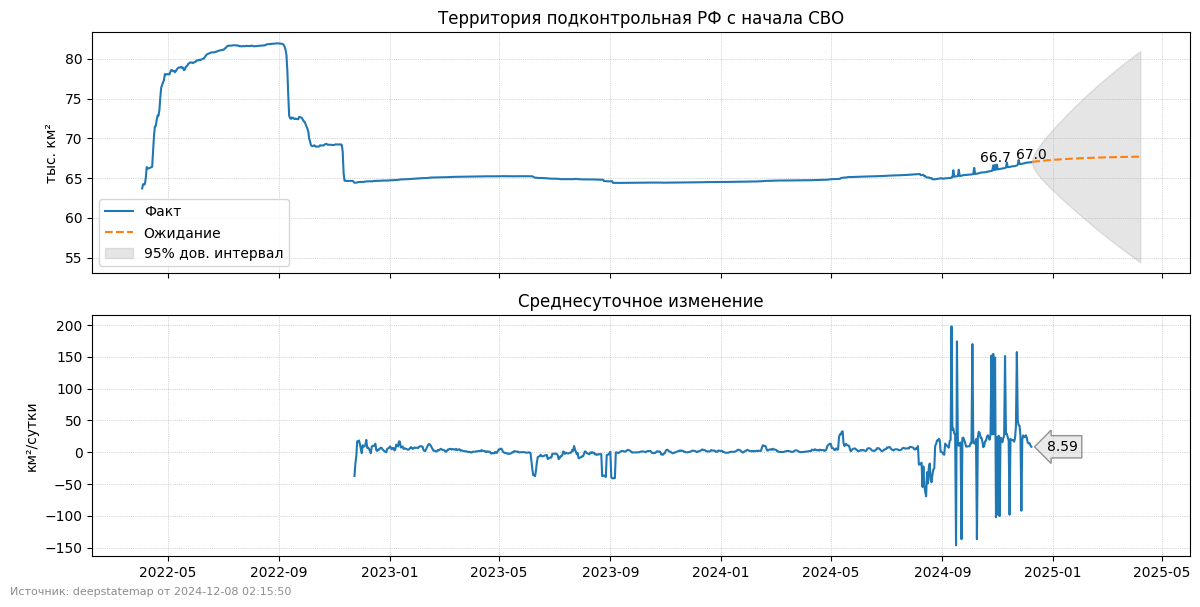

In [25]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)

ax.text(max_idx, max_val, f"{max_val:.1f}", ha="center", va="bottom")

ax.text(
    aa["area"].index.max(),
    aa["area"].iloc[-1] / 1000,
    f'{aa['area'].iloc[-1]/1000:.1f}',
    ha="center",
    va="bottom",
)

ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = aa.diff()["2022-11-23":].rolling(5, center=True, min_periods=3).mean()
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=16 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)